## Data Loading and Preprocessing

In [40]:
import pandas as pd
import datetime as dt

# Load dataset
df = pd.read_excel(r'D:\Desktop\ElevateLabs(DataScienceintern)\Project Tasks\CLTV_Prediction_Project\Data\online+retail\Online Retail.xlsx')
df.dropna(subset=['CustomerID'], inplace=True)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df = df[~df['StockCode'].isin(['POST', 'D'])]

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Converting InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

#reference date
reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

#Outlier Removal
Q1 = df[['Quantity', 'UnitPrice']].quantile(0.25)
Q3 = df[['Quantity', 'UnitPrice']].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[['Quantity', 'UnitPrice']] < (Q1 - 1.5 * IQR)) | (df[['Quantity', 'UnitPrice']] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Aggregate for CLTV metrics
cltv_df = df.groupby('CustomerID').agg({
    'InvoiceDate': [
        lambda x: (x.max() - x.min()).days,  # recency
        lambda x: (reference_date - x.min()).days  # T
    ],
    'InvoiceNo': 'nunique',  # frequency
    'TotalPrice': 'sum'      # total monetary value
})
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
cltv_df = cltv_df[cltv_df['frequency'] > 1]  # remove 1-time buyers
cltv_df['recency'] = cltv_df['recency'] / 7  # convert to weeks
cltv_df['T'] = cltv_df['T'] / 7
cltv_df['monetary'] = cltv_df['monetary'] / cltv_df['frequency']  # avg value

#validation
print("Negative or zero Quantity:", (df['Quantity'] <= 0).sum())
print("Negative or zero UnitPrice:", (df['UnitPrice'] <= 0).sum())

Negative or zero Quantity: 0
Negative or zero UnitPrice: 0


## RFM Analysis

In [4]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']


## RFM Segmentation

In [5]:
rfm['R_quartile'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F_quartile'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M_quartile'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

rfm['RFMScore'] = rfm.R_quartile.astype(str) + rfm.F_quartile.astype(str) + rfm.M_quartile.astype(str)

def segment_customer(score):
    if score >= '444': return 'Champions'
    elif score >= '344': return 'Loyal'
    elif score >= '244': return 'Potential Loyalist'
    elif score >= '111': return 'At Risk'
    else: return 'Others'
rfm['Segment'] = rfm['RFMScore'].apply(segment_customer)

## Visualizing Recency Distribution Across Segments

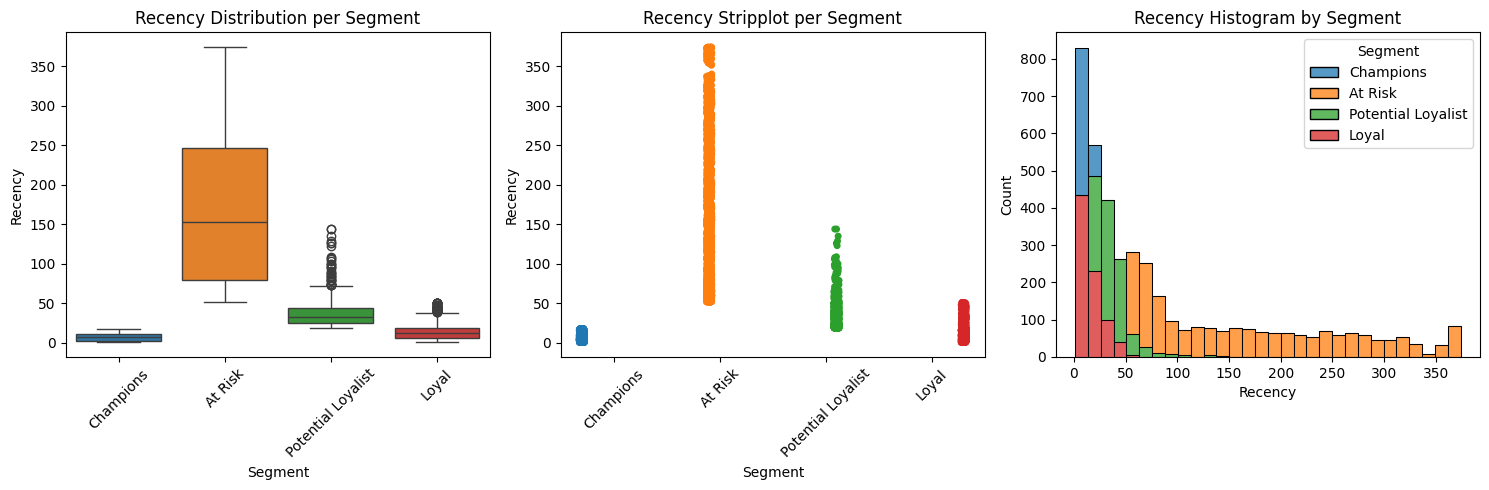

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))

# Boxplot
plt.subplot(1, 3, 1)
sns.boxplot(data=rfm, x='Segment', y='Recency', hue='Segment', palette='tab10')
plt.title('Recency Distribution per Segment')
plt.legend([],[],frameon=False)
plt.xticks(rotation=45)

# Stripplot
plt.subplot(1, 3, 2)
sns.stripplot(data=rfm, x='Segment', y='Recency', hue='Segment', palette='tab10', dodge=True, legend=False)
plt.title('Recency Stripplot per Segment')
plt.xticks(rotation=45)

# Histogram
plt.subplot(1, 3, 3)
sns.histplot(data=rfm, x='Recency', hue='Segment', multiple='stack', palette='tab10', bins=30)
plt.title('Recency Histogram by Segment')

plt.tight_layout()
plt.show()


## CLTV Calculation and Segmentation

In [7]:
# Avoid divide by zero
rfm = rfm[rfm['Frequency'] > 0]

# Calculate AOV
rfm['AOV'] = rfm['Monetary'] / rfm['Frequency']

# Purchase Frequency
purchase_frequency = rfm['Frequency'].sum() / rfm.shape[0]

# Repeat Rate and Churn Rate
repeat_rate = rfm[rfm['Frequency'] > 1].shape[0] / rfm.shape[0]
churn_rate = 1 - repeat_rate

# Profit Margin (assumption 5%)
profit_margin = 0.05

# CLTV Formula
rfm['CLTV'] = ((rfm['AOV'] * purchase_frequency) / churn_rate) * profit_margin

# Segment CLTV into tiers
rfm['CLTV_Segment'] = pd.cut(rfm['CLTV'], 
                             bins=[0, 100, 500, 1000, rfm['CLTV'].max()], 
                             labels=['Low', 'Medium', 'High', 'Very High'])


## Visualizing CLTV Distribution Across Segments (Log Scale)

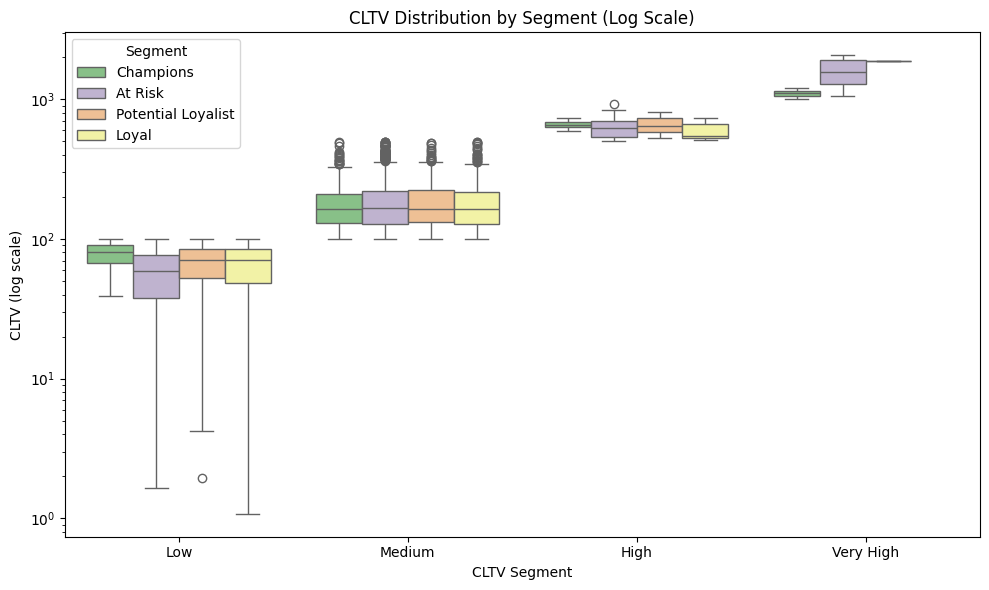

In [8]:

plt.figure(figsize=(10, 6))
sns.boxplot(data=rfm, x='CLTV_Segment', y='CLTV', palette='Accent',hue='Segment', dodge=True, legend=True)
plt.yscale('log')
plt.title('CLTV Distribution by Segment (Log Scale)')
plt.xlabel('CLTV Segment')
plt.ylabel('CLTV (log scale)')
plt.tight_layout()
plt.show()


## Customer Distribution by CLTV Segment

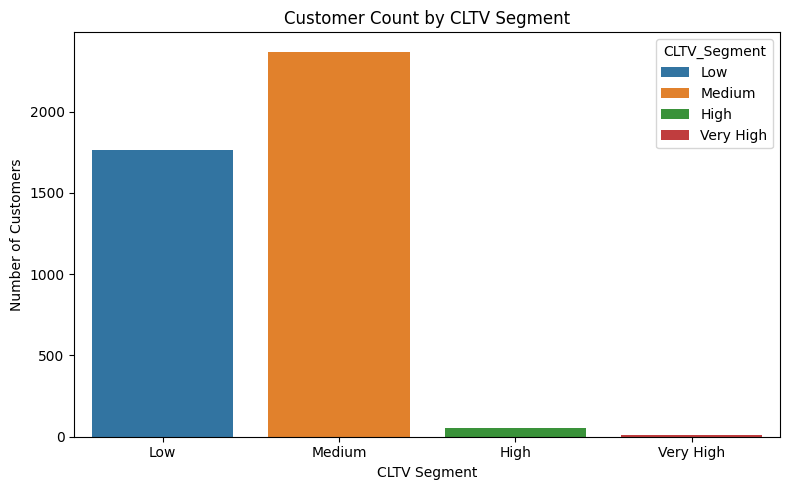

In [9]:
plt.figure(figsize=(8, 5))
sns.countplot(data=rfm, x='CLTV_Segment', hue='CLTV_Segment', palette='tab10', legend=True)
plt.title('Customer Count by CLTV Segment')
plt.ylabel('Number of Customers')
plt.xlabel('CLTV Segment')
plt.tight_layout()
plt.show()


## Frequency vs. Monetary Value by CLTV Segment (Log Scale)

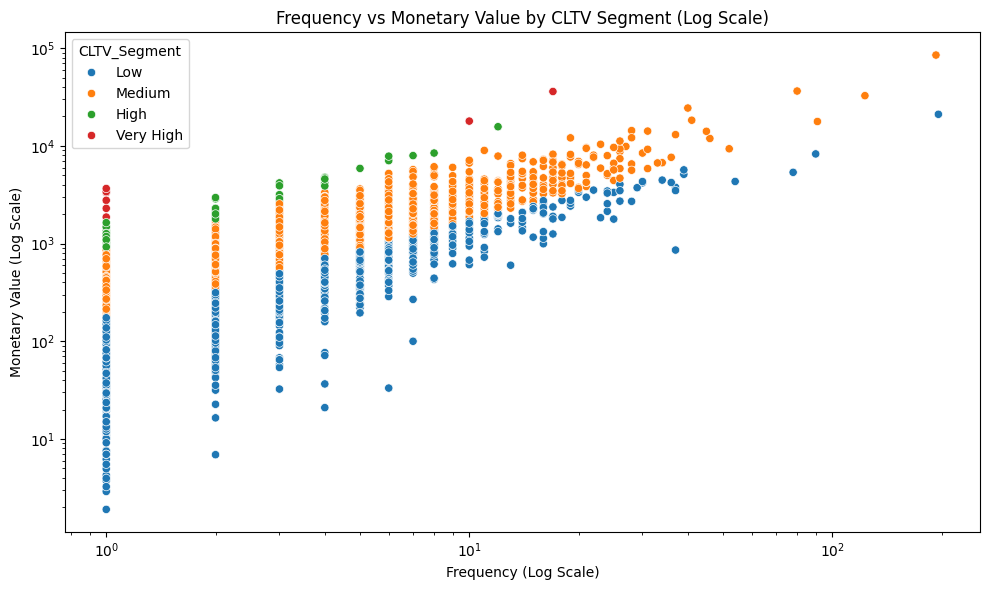

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='CLTV_Segment', palette='tab10')
plt.xscale('log')
plt.yscale('log')
plt.title('Frequency vs Monetary Value by CLTV Segment (Log Scale)')
plt.xlabel('Frequency (Log Scale)')
plt.ylabel('Monetary Value (Log Scale)')
plt.tight_layout()
plt.show()

## Descriptive Statistics for Transactions and RFM Metrics

In [26]:
from IPython.display import display

# Display descriptive stats for selected columns
display(df[['Quantity', 'UnitPrice', 'TotalPrice']].describe().round(2).style.set_caption("Transaction Summary"))

# Display descriptive stats for RFM metrics
display(rfm.describe().round(2).style.set_caption("RFM Summary"))


,Quantity,UnitPrice,TotalPrice
count,338137.000000,338137.000000,338137.000000
mean,7.480000,2.190000,12.770000
std,6.770000,1.540000,13.180000
min,1.000000,0.000000,0.000000
25%,2.000000,1.250000,3.800000
50%,6.000000,1.650000,10.080000
75%,12.000000,2.950000,17.400000
max,27.000000,7.500000,178.800000


,Recency,Frequency,Monetary,AOV,CLTV
count,4191.000000,4191.000000,4191.000000,4191.000000,4191.000000
mean,92.490000,4.010000,1030.500000,251.120000,142.050000
std,99.910000,7.020000,2205.550000,212.750000,120.340000
min,1.000000,1.000000,1.900000,1.900000,1.070000
25%,18.000000,1.000000,207.940000,127.710000,72.240000
50%,51.000000,2.000000,468.890000,205.920000,116.480000
75%,144.000000,4.000000,1135.360000,314.040000,177.640000
max,374.000000,196.000000,85018.780000,3659.970000,2070.210000


## Visualize RFM Metrics Distribution:

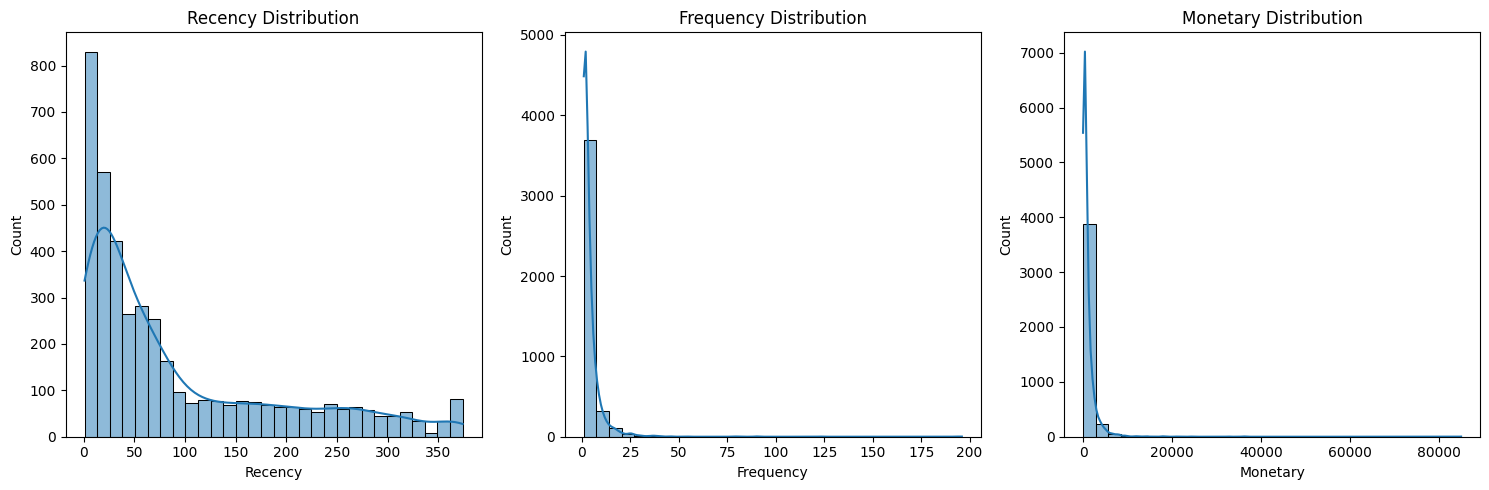

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], bins=30, kde=True)
plt.title('Recency Distribution')
plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], bins=30, kde=True)
plt.title('Frequency Distribution')
plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'], bins=30, kde=True)
plt.title('Monetary Distribution')
plt.tight_layout()
plt.show()

## Data Splitting and LTV Calculation

In [14]:
train_end_date = df['InvoiceDate'].min() + pd.Timedelta(days=270)  # First 9 months
train_df = df[df['InvoiceDate'] <= train_end_date]
test_df = df[df['InvoiceDate'] > train_end_date]

# Recalculate RFM for training period
reference_date = train_end_date + pd.Timedelta(days=1)
rfm_train = train_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

# Calculate actual LTV for test period
ltv_test = test_df.groupby('CustomerID')['TotalPrice'].sum().rename('LTV')

# Merge RFM features with LTV
data = rfm_train.merge(ltv_test, on='CustomerID', how='inner')

## Random Forest Model Training and Feature Importance

RMSE: 577.4047466722278
R2 Score: 0.3148642929532419


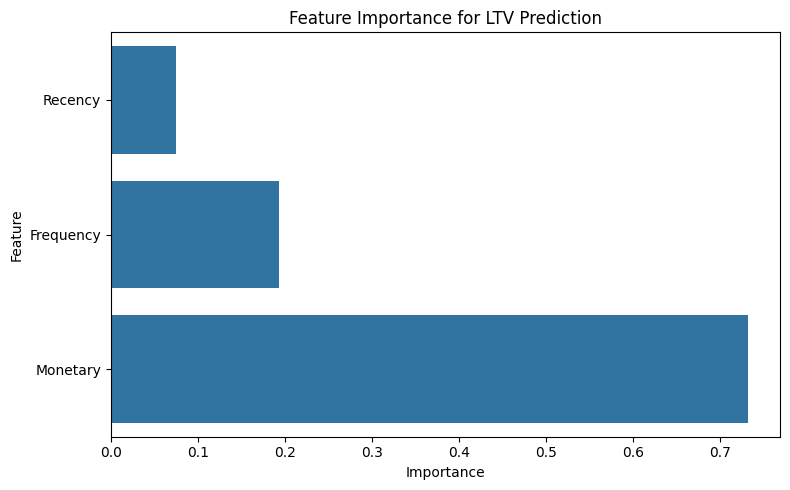

In [27]:
from sklearn.metrics import mean_squared_error
import numpy as np
X = data[['Recency', 'Frequency', 'Monetary']]
y = data['LTV']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)  # Add this line to generate predictions
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)
print("R2 Score:", r2_score(y_test, y_pred))

# Feature importance visualization
importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
plt.figure(figsize=(8, 5))
sns.barplot(data=importance, x='Importance', y='Feature')
plt.title('Feature Importance for LTV Prediction')
plt.tight_layout()
plt.show()

## Customer Segmentation and Model Evaluation using KMeans Clustering and Cross-Validation

Cross-Validation R2 Scores: [0.38008784 0.4883683  0.47570509 0.32618195 0.63762103]
Average R2: 0.46159284223728514


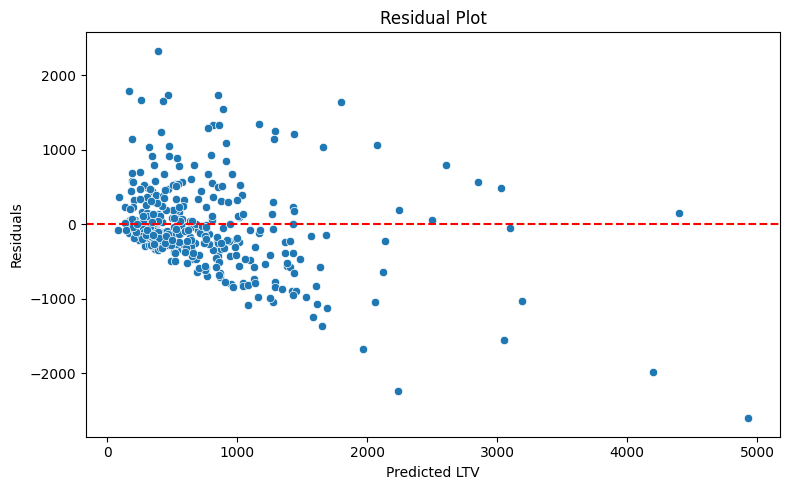

,Recency,Frequency,Monetary,LTV
SegmentName,,,,
At Risk,84.200000,2.620000,505.590000,432.680000
Champions,4.670000,78.670000,26700.850000,24657.520000
Loyal Customers,13.400000,19.420000,6457.810000,3589.880000
Potential Loyalist,34.970000,7.720000,2185.470000,1325.590000


In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
import pandas as pd
from IPython.display import display
scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("Cross-Validation R2 Scores:", scores)
print("Average R2:", scores.mean())
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted LTV')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()
# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
data['Segment'] = kmeans.fit_predict(data[['Recency', 'Frequency', 'Monetary', 'LTV']])

segment_names = {
    0: 'Potential Loyalist',
    1: 'Champions',
    2: 'At Risk',
    3: 'Loyal Customers'
}

data['SegmentName'] = data['Segment'].map(segment_names)

segment_summary_named = data.groupby('SegmentName').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'LTV': 'mean'
}).round(2)

# Display the summary
display(segment_summary_named.style.set_caption("Customer Segment Summary"))

## Hyperparameter Tuning for Random Forest Regression using Grid Search and Cross-Validation

In [24]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best R2 Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 10, 'n_estimators': 50}
Best R2 Score: 0.5095486673990767


 ## Save Trained Model

In [44]:
from lifetimes import BetaGeoFitter, GammaGammaFitter
import dill

# Fit BG/NBD model
bgf = BetaGeoFitter()
bgf.fit(cltv_df['frequency'], cltv_df['recency'], cltv_df['T'])

# Fit Gamma-Gamma model
ggf = GammaGammaFitter()
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

# Save both models to files using dill to handle lambda functions
with open('bgf_model.pkl', 'wb') as f:
    dill.dump(bgf, f)

with open('ggf_model.pkl', 'wb') as f:
    dill.dump(ggf, f)



## Final LTV Predictions CSV

In [46]:
cltv_df.to_csv("predicted_cltv.csv", index=False)
